#Project_NLP: ag_news_subset

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import tensorflow_hub as hub

##Getting the Data

In [2]:
(train_data,test_data), info= tfds.load('ag_news_subset', split=['train','test'],
                                                shuffle_files=True, as_supervised=True,
                                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteQM5AV9/ag_news_subset-train.tfrecord*...:  …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteQM5AV9/ag_news_subset-test.tfrecord*...:   …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [3]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles. News articles have been
    gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
    activity. ComeToMyHead is an academic news search engine which has been running
    since July, 2004. The dataset is provided by the academic comunity for research
    purposes in data mining (clustering, classification, etc), information retrieval
    (ranking, search, etc), xml, data compression, data streaming, and any other
    non-commercial activity. For more information, please refer to the link
    http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang
    (xiang.zhang@nyu.edu) from the dataset above. It is used as a text
    classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann
    LeCu

In [4]:
class_names = info.features['label'].names
num_classes = info.features['label'].num_classes

print(f'The news are grouped into {num_classes} classes that are :{class_names}')

The news are grouped into 4 classes that are :['World', 'Sports', 'Business', 'Sci/Tech']


In [5]:
num_train = info.splits['train'].num_examples
num_test = info.splits['test'].num_examples

print(f'The number of training samples: {num_train} \nThe number of test samples: {num_test}')

The number of training samples: 120000 
The number of test samples: 7600


In [3]:
# tfds.show_examples(train_dataset, info)
news_df=tfds.as_dataframe(train_data.take(120000), info)
news_df.head()

,description,label
0,b'AMD #39;s new dual-core Opteron chip is desi...,3
1,b'Reuters - Major League Baseball\\Monday anno...,1
2,b'President Bush #39;s quot;revenue-neutral q...,2
3,b'Britain will run out of leading scientists u...,3
4,"b'London, England (Sports Network) - England m...",1


In [4]:
sentences = news_df['description'].to_list()
labels =  news_df['label'].to_list()

In [8]:
type(sentences[0])

bytes

In [9]:
type(labels[0])

int

In [10]:
print(sentences[0].split())

[b'AMD', b'#39;s', b'new', b'dual-core', b'Opteron', b'chip', b'is', b'designed', b'mainly', b'for', b'corporate', b'computing', b'applications,', b'including', b'databases,', b'Web', b'services,', b'and', b'financial', b'transactions.']


In [11]:
print(len(sentences))

120000


In [5]:
sentences2=[]
for i in range(len(sentences)):
  decoded_string= sentences[i].decode("utf-8")
  sentences2.append(decoded_string)

In [13]:
type(sentences2[0])

str

In [14]:
len(sentences2)

120000

In [15]:
sentences2[0]

'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'

##Preparing the Data

In [7]:
for i in range(len(sentences2)):
    words = sentences2[i].split()
    # List Comprehension
    words2 = [w for w in words if w not in sw]
    sentences2[i] = ' '.join(words2)

In [18]:
sentences2[0]

'AMD #39;s new dual-core Opteron chip designed mainly corporate computing applications, including databases, Web services, financial transactions.'

In [19]:
len(sentences2[0].split())

17

In [8]:
TRAIN_SIZE = 110000
MAX_TOKENS = 10000
SEQUENCE_LENGTH= 30
EMBEDDING_DIM=10

In [9]:
train_sentences = np.array(sentences2[0:TRAIN_SIZE])
validation_sentences = np.array(sentences2[TRAIN_SIZE:])

train_labels = np.array(labels[0:TRAIN_SIZE])
validation_labels = np.array(labels[TRAIN_SIZE:])

In [10]:
vectorizer= layers.TextVectorization(max_tokens=MAX_TOKENS,
                                     output_sequence_length=SEQUENCE_LENGTH)
vectorizer.adapt(train_sentences)
print(len(vectorizer.get_vocabulary()))

10000


In [11]:
train_sequences=vectorizer(train_sentences)
validation_sequences=vectorizer(validation_sentences)
print(train_sequences.shape)
print(validation_sequences.shape)

(110000, 30)
(10000, 30)


##Model Design

In [24]:
model1= Sequential([
    layers.Embedding(MAX_TOKENS,EMBEDDING_DIM),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16,activation='relu'),
    layers.Dense(4, activation='softmax')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          100000    
                                                                 
 global_average_pooling1d (  (None, 10)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                176       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 100244 (391.58 KB)
Trainable params: 100244 (391.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy'
              , metrics=['accuracy'])

In [26]:
history1 = model1.fit(train_sequences,train_labels,
                    batch_size=32,
                    epochs=10,
                    validation_data=(validation_sequences,validation_labels))

Epoch 1/10
3438/3438 [==============================] - 37s 10ms/step - loss: 0.4838 - accuracy: 0.8430 - val_loss: 0.3286 - val_accuracy: 0.8931
Epoch 2/10
3438/3438 [==============================] - 15s 4ms/step - loss: 0.2739 - accuracy: 0.9090 - val_loss: 0.2995 - val_accuracy: 0.9011
Epoch 3/10
3438/3438 [==============================] - 14s 4ms/step - loss: 0.2315 - accuracy: 0.9221 - val_loss: 0.2923 - val_accuracy: 0.9002
Epoch 4/10
3438/3438 [==============================] - 13s 4ms/step - loss: 0.2072 - accuracy: 0.9295 - val_loss: 0.2974 - val_accuracy: 0.9005
Epoch 5/10
3438/3438 [==============================] - 13s 4ms/step - loss: 0.1913 - accuracy: 0.9345 - val_loss: 0.3080 - val_accuracy: 0.8973
Epoch 6/10
3438/3438 [==============================] - 13s 4ms/step - loss: 0.1799 - accuracy: 0.9375 - val_loss: 0.3150 - val_accuracy: 0.8988
Epoch 7/10
3438/3438 [==============================] - 13s 4ms/step - loss: 0.1705 - accuracy: 0.9413 - val_loss: 0.3270 - val_a

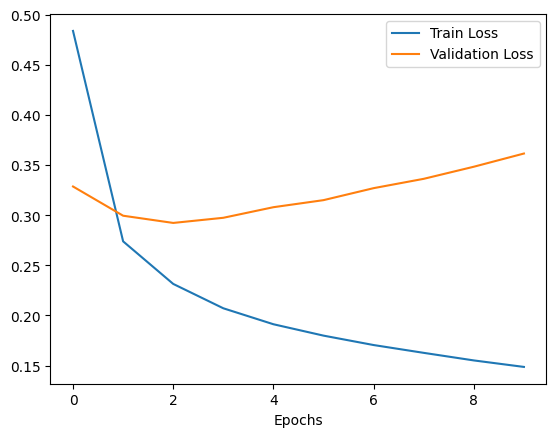

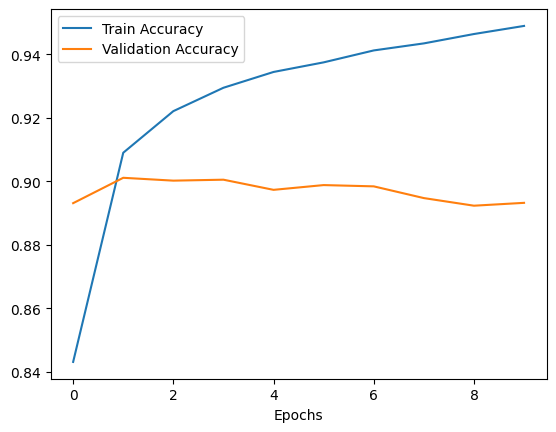

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(history1.history['loss'], label='Train Loss')
ax.plot(history1.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.plot(history1.history['accuracy'], label='Train Accuracy')
ax.plot(history1.history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

##Using Pre_train embedding



In [17]:
hub_layer = hub.KerasLayer(
"https://kaggle.com/models/google/gnews-swivel/frameworks/TensorFlow2/variations/tf2-preview-20dim/versions/1",
output_shape=[20], input_shape=[],
dtype=tf.string, trainable=False
)

In [21]:
model2= Sequential([
    hub_layer,
    layers.Dense(16,activation='relu'),
    layers.Dense(4, activation='softmax')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_4 (Dense)             (None, 16)                336       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 400424 (1.53 MB)
Trainable params: 404 (1.58 KB)
Non-trainable params: 400020 (1.53 MB)
_________________________________________________________________


In [22]:
model2.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [23]:
history2 = model2.fit(train_sentences,train_labels,
                    batch_size=32,
                    epochs=50,
                    validation_data=(validation_sentences,validation_labels))

Epoch 1/50
3438/3438 [==============================] - 16s 4ms/step - loss: 2.0688 - accuracy: 0.2448 - val_loss: 1.7819 - val_accuracy: 0.3018
Epoch 2/50
3438/3438 [==============================] - 15s 4ms/step - loss: 1.5558 - accuracy: 0.3750 - val_loss: 1.3643 - val_accuracy: 0.4495
Epoch 3/50
3438/3438 [==============================] - 15s 4ms/step - loss: 1.2010 - accuracy: 0.5403 - val_loss: 1.0684 - val_accuracy: 0.6179
Epoch 4/50
3438/3438 [==============================] - 15s 4ms/step - loss: 0.9542 - accuracy: 0.6763 - val_loss: 0.8698 - val_accuracy: 0.7155
Epoch 5/50
3438/3438 [==============================] - 15s 4ms/step - loss: 0.7958 - accuracy: 0.7410 - val_loss: 0.7464 - val_accuracy: 0.7567
Epoch 6/50
3438/3438 [==============================] - 15s 4ms/step - loss: 0.6986 - accuracy: 0.7708 - val_loss: 0.6704 - val_accuracy: 0.7790
Epoch 7/50
3438/3438 [==============================] - 17s 5ms/step - loss: 0.6387 - accuracy: 0.7873 - val_loss: 0.6229 - val_ac

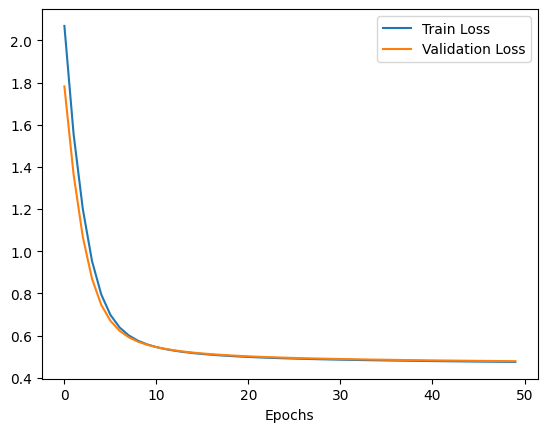

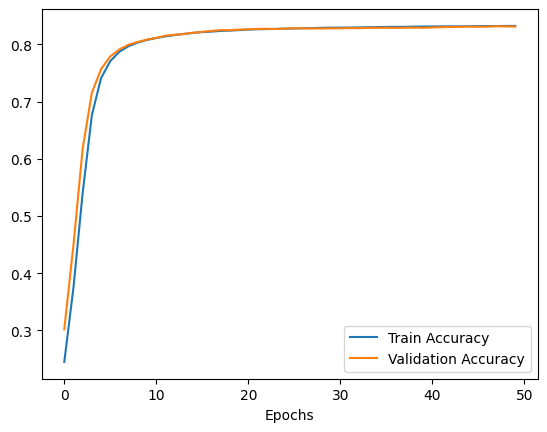

In [25]:
fig, ax = plt.subplots(1, 1)
ax.plot(history2.history['loss'], label='Train Loss')
ax.plot(history2.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.plot(history2.history['accuracy'], label='Train Accuracy')
ax.plot(history2.history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

In [29]:
test_sentences= ["Canadian Press - VANCOUVER (CP) - The sister of a man who died after a violent confrontation with police has demanded the city's chief constable resign for defending the officer involved.",
                 "Michael Phelps won the gold medal in the 400 individual medley and set a world record in a time of 4 minutes 8.26 seconds.",
                 "Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.",
                 "Dolphin groups, or pods, rely on socialites to keep them from collapsing, scientists claim."]

In [31]:
## label_sentences1: 1
## label_sentences2: 2
## label_sentences3: 3
## label_sentences4: 4
preds= model2.predict(test_sentences)
print(preds)

1/1 [==============================] - 0s 46ms/step
[[0.97714216 0.00693498 0.00897091 0.00695195]
 [0.0127233  0.9541079  0.01026134 0.02290758]
 [0.26503512 0.16744871 0.50362545 0.06389064]
 [0.2228806  0.01499788 0.1054458  0.6566757 ]]
